# Playground ImageNet

In [1]:
import argparse
import numpy as np
from PIL import Image
import pickle
from utils import *
import os
import matplotlib as mpl
mpl.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import numpy as np
import argparse
import math
import os
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

In [2]:
path = '/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/train_data_batch_1'

In [3]:

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    d = unpickle(data_file + str(idx))
    x = d['data']
    y = d['labels']
    mean_image = d['mean']

    x = x/np.float32(255)
    mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]
    data_size = x.shape[0]

    x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

    # create mirrored images
    X_train = x[0:data_size, :, :, :]
    Y_train = y[0:data_size]
    X_train_flip = X_train[:, :, :, ::-1]
    Y_train_flip = Y_train
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

    return dict(
        X_train=(X_train), # lasagne.utils.floatX(X_train),
        Y_train=Y_train.astype('int32'),
        mean=mean_image)



def load_data(input_file):

    d = unpickle(input_file)
    x = d['data']
    y = d['labels']
    
    mean_image = d['mean']

    print(x.shape, 'x')
    print(len(y), 'y')
    print(mean_image.shape, 'mean')

    x = x/np.float32(255)
    mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]

    x -= mean_image

    x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))
    x = x.reshape((x.shape[0], 32, 32, 3))

    return x, y

def load_data_test(input_file):

    d = unpickle(input_file)
    x = d['data']
    y = d['labels']

    mean_image = []
    for i in x:
        mean_image.append(np.mean(i))
    mean_image = np.array(mean_image)

    print(x.shape, 'x')
    print(len(y), 'y')
    print(mean_image.shape, 'mean')
    
    x = x/np.float32(255)
    mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]

    x -= mean_image

    x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))
    x = x.reshape((x.shape[0], 32, 32, 3))

    return x, y



In [80]:
x, y = load_data(path)

(128116, 3072) x
128116 y
(3072,) mean


In [61]:
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'list'>


In [62]:
a_set = set(y)
number_of_unique_values = len(a_set)
print(number_of_unique_values)

1000


In [13]:
(Image.fromarray(x[0]) )

TypeError: Cannot handle this data type: (1, 1, 3), <f4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


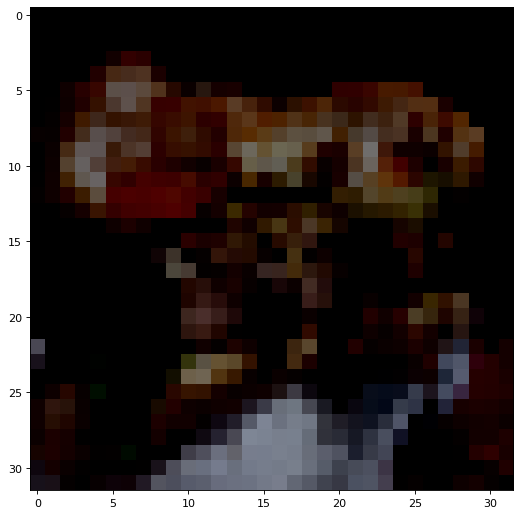

In [8]:
figure(figsize=(8, 8), dpi=80)
plt.imshow(x[0], interpolation='nearest')
plt.show()

/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid 

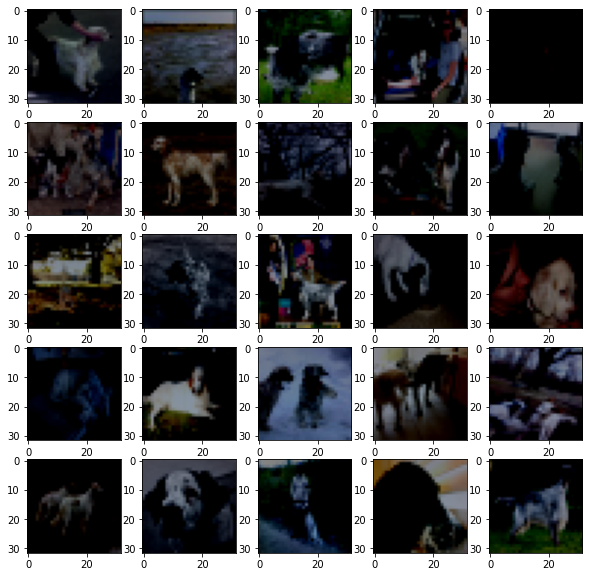

In [9]:
w = 15
h = 15

fig = plt.figure(figsize=(10, 10))

columns = 5
rows = 5

c = 1    # Define which class you want to depict
ims_ind = np.where(np.array(y) == c)[0]
ims = x[[ims_ind]]

for i in range(1, columns*rows +1):
    img = ims[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [14]:
c = 2 # Define which class you want to depict
ims = np.where(np.array(y) == c)[0]

In [16]:
if __name__ == '__main__':
    args = parse_args()
    # input_file, gen_images, hist_sorted  = parse_args()
    x, y = load_data(args.input_file)

    # Lets save all images from this file
    # Each image will be 3600x3600 pixels (10 000) images

    blank_image = None
    curr_index = 0
    image_index = 0

    print('First image in dataset:')
    print(x[curr_index])

    if not os.path.exists('res'):
        os.makedirs('res')

    if args.gen_images:
        for i in range(x.shape[0]):
            if curr_index % 10000 == 0:
                if blank_image is not None:
                    print('Saving 10 000 images, current index: %d' % curr_index)
                    blank_image.save('res/Image_%d.png' % image_index)
                    image_index += 1
                blank_image = Image.new('RGB', (36*100, 36*100))
            x_pos = (curr_index % 10000) % 100 * 36
            y_pos = (curr_index % 10000) // 100 * 36

            blank_image.paste(Image.fromarray(x[curr_index]), (x_pos + 2, y_pos + 2))
            curr_index += 1

        blank_image.save('res/Image_%d.png' % image_index)

    graph = [0] * 1000


NameError: name 'parse_args' is not defined

# Histogram

In [17]:
for i in range(x.shape[0]):
    # Labels start from 1 so we have to subtract 1
    graph[y[i]-1] += 1

if args.sorted_histogram:
    graph.sort()
    
x = [i for i in range(1000)]
ax = plt.axes()
plt.bar(x = x, height=graph, color='darkblue', edgecolor='darkblue') # left=x
ax.set_xlabel('Class', fontsize=20)
ax.set_ylabel('Samples', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('res/Samples.pdf', format='pdf', dpi=1200)

NameError: name 'graph' is not defined

# Test

In [4]:
x,y = load_data_test('/Users/dj/Desktop/MT_Desktop/ImageNet/val_data')

print(type(x))
print(type(y))

print(len(x))
print(len(y))

(50000, 3072) x
50000 y
(50000,) mean


ValueError: operands could not be broadcast together with shapes (50000,3072) (50000,) (50000,3072) 

In [29]:
test_means = []
for i in x:
    test_means.append(np.mean(i))

In [58]:
np.mean(test_means)

112.56165052734374

In [37]:
test_means[0]

115.55078125

In [50]:
for i in x:
    print((np.mean(i)))
    break

115.55078125


In [51]:
np.mean((x[0]))

115.55078125

In [57]:
t = 6
abc = x[t] - test_means[t]
np.mean(abc)

-5.921189464667502e-15

# Creating one big file

In [26]:
os.listdir('/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/')

['train_data_batch_8',
 'train_data_batch_1',
 'train_data_batch_6',
 'train_data_batch_7',
 'train_data_batch_9',
 'train_data_batch_10',
 'train_data_batch_5',
 'train_data_batch_2',
 'train_data_batch_3',
 'train_data_batch_4']

In [35]:
x.shape

(50000, 32, 32, 3)

In [62]:
test0 = np.array([[]])

In [63]:
print(type(test0))
print(len(test0))
print(test0.shape)

<class 'numpy.ndarray'>
1
(1, 0)


In [52]:
test = np.array([[1,2,3]])

In [53]:
print(type(test))
print(len(test))
print(test.shape)

<class 'numpy.ndarray'>
1
(1, 3)


In [54]:
test1 = np.array([[4,5,6]])

In [57]:
test2 = np.append(test, test1, axis = 0)

In [58]:
print(test2)
print(type(test2))
print(len(test2))
print(test2.shape)

[[1 2 3]
 [4 5 6]]
<class 'numpy.ndarray'>
2
(2, 3)


# Traindata

In [3]:
path = '/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/'
counter = 0

for i in os.listdir('/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/'):
    counter += 1
    total_path = path + i

    x,y = load_data(total_path)

    if counter == 1:
        x_train, y_train = x, y
    else:
        x_train = np.append(x_train, x, axis = 0)
        y_train = y_train + y


In [4]:
print(len(x_train))
print(len(y_train))
print(x_train.shape)

1281167
1281167
(1281167, 32, 32, 3)


In [6]:
def create_tuples(x,y):
    samps = []

    for i in tqdm(np.arange(0,len(x),1)):
        t = torch.Tensor(x[i]).view(3,32,32)
        tup = (t, int(y[i]))
        samps.append(tup)
    return samps

In [7]:
dat_train = create_tuples(x_train, y_train)

100%|██████████| 1281167/1281167 [00:28<00:00, 45471.63it/s]


In [8]:
print(dat_train[0][0].shape)
# test = dat_train[0][0].view(3,32,32)
# test.shape

torch.Size([3, 32, 32])


In [10]:
trainset = torch.utils.data.DataLoader(dat_train, batch_size = 10, shuffle = True)

In [11]:
for data in trainset:
    x, y = data
    print(x.shape)
    break

torch.Size([10, 3, 32, 32])


In [12]:
x_test,y_test = load_data('/Users/dj/Desktop/MT_Desktop/ImageNet/val_data')
print(type(x_test))
print(type(y_test))
dat_test = create_tuples(x_test, y_test)

<class 'numpy.ndarray'>
<class 'list'>


100%|██████████| 50000/50000 [00:00<00:00, 77159.19it/s]


In [13]:
type(y_test[0])

int

In [14]:
testset = torch.utils.data.DataLoader(dat_test, batch_size = 10, shuffle = True)

In [15]:
for data in testset:
    x,y = data
    print(x.shape)
    break

torch.Size([10, 3, 32, 32])


In [83]:
l = [[1,2,3],
[4,5,6]]

In [84]:
l = np.array(l)

In [87]:
np.mean(l, axis=0)

array([2.5, 3.5, 4.5])